In [1]:
import numpy as np
from sklearn.utils import shuffle
from keras.utils import np_utils

terrain_classes = ('Plano', 'DM', 'Elevaciones')

x = np.load('processed_terrain_data.npy')
y = np.load('terrain_data_labels.npy')

x, y = shuffle(x, y)

x_train, x_val, x_test = np.split(
    np.array(x), [int(len(x)*0.7), int(len(x)*0.85)])
y_train, y_val, y_test = np.split(
    np.array(y), [int(len(y)*0.7), int(len(y)*0.85)])

y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

n_clases = len(terrain_classes)
n_features = len(x[0])

print(np.unique(y, return_counts=True))
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))
print(len(x_test))
print(len(y_test))
print(n_clases)
print(n_features)


2021-11-13 19:00:36.340389: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


(array([0, 1, 2]), array([1765,  618,  840]))
2256
2256
483
483
484
484
3
12


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import backend

# We want to make sure we start from the start when training our model everytime we run it.
backend.clear_session()

# Define MLP model
model = Sequential()
model.add(Dense(64, input_dim=n_features, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_clases, activation='softmax'))


2021-11-13 19:00:37.587389: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-13 19:00:37.599923: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-13 19:00:38.101906: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-13 19:00:38.101957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.215GHz coreCount: 46 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 357.69GiB/s
2021-11-13 19:00:38.102016: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-13 19:00:38.103588: I tensorflow/stre

In [3]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 5,187
Trainable params: 5,187
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])


In [5]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('terrain_best_model.h5', monitor='val_accuracy',
                     mode='max', verbose=1, save_best_only=True)
# Fit model
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y),
                                                  y)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), class_weight=(
    dict(zip(np.unique(y), class_weights))), epochs=150, batch_size=6, callbacks=[es, mc])


/home/hivini/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
2021-11-13 19:00:39.781983: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-13 19:00:39.782482: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2208005000 Hz


Epoch 1/150


2021-11-13 19:00:40.150008: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


376/376 [==============================] - 3s 7ms/step - loss: 7.7060 - accuracy: 0.3508 - val_loss: 2.7850 - val_accuracy: 0.5197

Epoch 00001: val_accuracy improved from -inf to 0.51967, saving model to terrain_best_model.h5
Epoch 2/150
376/376 [==============================] - 2s 6ms/step - loss: 3.6473 - accuracy: 0.5401 - val_loss: 2.1742 - val_accuracy: 0.6936

Epoch 00002: val_accuracy improved from 0.51967 to 0.69358, saving model to terrain_best_model.h5
Epoch 3/150
376/376 [==============================] - 2s 6ms/step - loss: 4.8834 - accuracy: 0.5503 - val_loss: 1.9787 - val_accuracy: 0.6522

Epoch 00003: val_accuracy did not improve from 0.69358
Epoch 4/150
376/376 [==============================] - 3s 7ms/step - loss: 1.7344 - accuracy: 0.6433 - val_loss: 2.0130 - val_accuracy: 0.6894

Epoch 00004: val_accuracy did not improve from 0.69358
Epoch 5/150
376/376 [==============================] - 3s 7ms/step - loss: 3.0427 - accuracy: 0.6229 - val_loss: 3.5360 - val_accurac

In [6]:
from tensorflow import keras

model = keras.models.load_model('terrain_best_model.h5')
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_acc)


16/16 [==============================] - 0s 7ms/step - loss: 0.9588 - accuracy: 0.6880
Loss on test set:  0.9588064551353455
Accuracy on test set:  0.6880165338516235


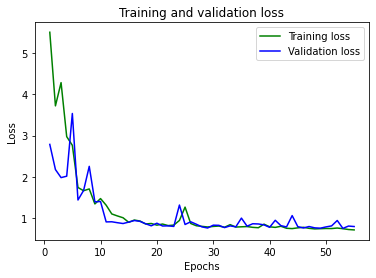

In [7]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
# bo is for blue dot.
plt.plot(epochs, loss, 'g', label='Training loss')
# b is for solid blue line
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


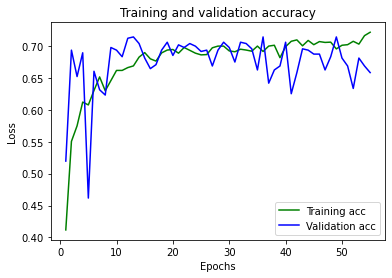

In [8]:
plt.clf()

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
